In [2]:
import os
import sys
print(os.getcwd())
# change working directory to project root
import platform
if platform.system() is "Windows":
    os.chdir('D:\\git\\cardio')
else:
    os.chdir('/Users/Code/Git/cardio')
print(os.getcwd())
from src.utils.utils_io import Console_and_file_logger, __ensure_dir__
from src.utils.myshow import myshow, myshow3d
from src.utils.file_wrapper.app.Files import Basefile, Dicomfile
from src.utils.file_wrapper.app.IO import FileWalker
import logging
Console_and_file_logger('series_Reader_1', logging.INFO)

import re
import nrrd
import numpy as np
from scipy import stats
from collections import OrderedDict
import json
import SimpleITK as sitk

D:\git\cardio\notebooks\sitk_tests
D:\git\cardio


D:\git\cardio\src\utils\file_wrapper\app\Files.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('TkAgg')
2018-12-03 13:28:30,627 INFO -------------------- Start --------------------
2018-12-03 13:28:30,650 INFO Filename: series_Reader_1
2018-12-03 13:28:30,651 INFO Log directory: ./logs/


Working directory: D:\git\cardio.
Log dir: ./logs/


In [2]:
class MyDicomfile(Dicomfile):
    """
    you need to implement:
    super Dicomfile alreadyknows how to open save and visualize a dcm image
    file_type
    def __init__(self, dir_name='./', filename='test.dcm', destination='./dest'):
    action(self):

    important, return the file for later statistics
    """
    file_type = '.dcm'

    def __init__(self,
                 dir_name='./',
                 filename='test.dcm',
                 destination='./dest'):
        super(MyDicomfile, self).__init__(dir_name, filename, destination)
        self.stats['filetype'] = self.__class__.file_type

    def action(self):
        logging.info('action performed')
        return self

In [3]:
src1 = 'data/raw/0001_small/1.3.12.2.1107.5.99.2.1013.30000008030612131778100062857'
src2 = 'data/raw/0001_small/1.3.12.2.1107.5.99.2.1013.30000008030612131778100062911'
dest = 'data/processed/small/test1'
os.listdir(os.getcwd())

fw1 = FileWalker(MyDicomfile, src_dir=src1, dest_dir=dest)
fw2 = FileWalker(MyDicomfile, src_dir=src2, dest_dir=dest)
#fw.log_stats()

In [4]:
img1 = fw1.open_files[0].img
img2 = fw2.open_files[0].img

# get the numpy array out of an dcm file
img1_nda = sitk.GetArrayViewFromImage(img1)
img2_nda = sitk.GetArrayViewFromImage(img2)

print(img1_nda)
print('numpy shape: {}'.format(img1_nda.shape))
print('sitk shape: {}'.format(img1.GetSize()))

[[[ 0 35 30 ... 23 32 32]
  [ 0 46 27 ... 28 32 32]
  [ 0 43 32 ... 20 18 33]
  ...
  [ 0 32 45 ... 30 40 44]
  [ 0 36 29 ... 24 27 29]
  [ 0 47 34 ... 29 29 24]]]
shape of numpy: (1, 168, 192)
shape of image: (192, 168, 1)


In [5]:
# visualize the dcm file with myshow
myshow3d(img1)


interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…

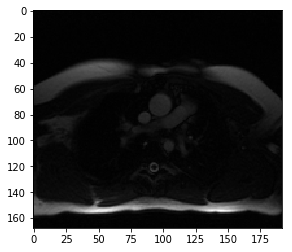

In [6]:
# use matplotlib
plt.imshow(sitk.GetArrayViewFromImage(img1[:,:,0]))


In [7]:
# show multiple dcm files
# [images per row, images per column, timesteps]
# here 1 image per row, two per column, 2 per timestemp, 
# because we dont have time steps jet, the second step is dark
slices = [img1, img2]
myshow3d(sitk.Tile(slices, [1, 2 ,2]), dpi=100)

interactive(children=(IntSlider(value=0, description='z', max=1), Output()), _dom_classes=('widget-interact',)…

In [6]:
# read one dcm series and plot it
# in our case we have 18 different time steps

series_src = './data/processed/Segmentations/0007/0007-0HQQW4ZN-2007-05-23/1.3.46.670589.11.0.0.11.4.2.0.5070.5.5892.2007052314282550951/'
series_dest = './data/processed/Segmentations/0007/series_join.nrrd'

logging.info("Reading Dicom directory: {}".format(series_src))
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(series_src)
reader.SetFileNames(dicom_names)

image = reader.Execute()

size = image.GetSize()
logging.info('image size: {}'.format(size))

logging.info("Writing image: {}".format(series_dest))

sitk.WriteImage(image, series_dest)

# if (not "SITK_NOSHOW" in os.environ):
#    sitk.Show(image, "Dicom Series")

#myshow3d(image)

2018-12-03 13:30:27,813 INFO Reading Dicom directory: ./data/processed/Segmentations/0007/0007-0HQQW4ZN-2007-05-23/1.3.46.670589.11.0.0.11.4.2.0.5070.5.5892.2007052314282550951/
2018-12-03 13:30:28,526 INFO image size: (256, 256, 250)
2018-12-03 13:30:28,526 INFO Writing image: ./data/processed/Segmentations/0007/series_join.nrrd


In [21]:
"""
resuable function for simplification
reads all dcom files in a directory
merge them and save them as one dcm file
all image types will be casted to uint16
to avoid exception of the sitkwriter class
"""

def merge_serie(source, destination):
    print( "Reading Dicom directory: {}".format(source))
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(source)
    
    print('merging files: {}'.format(len(dicom_names)))   
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    
    print('image size: {}'.format(image.GetSize()))
    size = image.GetSize()
    img_arr = sitk.GetArrayFromImage(image)
    
    # reshape, because it represents the time steps
    print('shape: {}'.format(img_arr.shape))
    
    img_arr = img_arr.reshape(10, 25, 256, 256)
    
    tdim = img_arr.shape[0]

    slices = []

    for t in range(tdim):
        slices.append( sitk.GetImageFromArray( img_arr[t], False ) )

    img = sitk.JoinSeries(slices)
    
    
    #print('shape: {}'.format(img_arr.shape))
    #image = sitk.GetImageFromArray(img_arr, )
    print('image size: {}'.format(img.GetSize()))
    #print('image type before casting: {}'.format(image.GetPixelIDTypeAsString()))
    
    # Convert floating type image to unsigned int type (imgFiltered)
    # All images from 0706 dataset are 64-bit float, sitk cant write this type
    #castFilter = sitk.CastImageFilter()
    #castFilter.SetOutputPixelType(sitk.sitkUInt16)
    #imgFiltered = castFilter.Execute(image)
    #print('image type after casting: {}'.format(imgFiltered.GetPixelIDTypeAsString()))
    
    print( "Writing image: {}".format(destination))
    sitk.WriteImage(img, destination)

    # if ( not "SITK_NOSHOW" in os.environ ):
    #      sitk.Show( image, "Dicom Series" )
    
    # myshow3d(image)
    #myshow3d(imgFiltered)

In [22]:
# read all dcm series for one patient and one series and plot it
# works fine, z axis = timestemps

series_src = './data/processed/Segmentations/0007/0007-0HQQW4ZN-2007-05-23/1.3.46.670589.11.0.0.11.4.2.0.5070.5.5892.2007052314282550951/'
series_dest = './data/processed/Segmentations/0007/series_join.nrrd'

#series_src = 'D:\\small\\tests\\0006-0AE4R74L-1900-01-01\\1.3.12.2.1107.5.99.2.1013.30000008030612131778100068128\\'
#series_dest = 'data/processed/test4.mhd'
merge_serie(series_src, series_dest)

Reading Dicom directory: ./data/processed/Segmentations/0007/0007-0HQQW4ZN-2007-05-23/1.3.46.670589.11.0.0.11.4.2.0.5070.5.5892.2007052314282550951/
merging files: 250
image size: (256, 256, 250)
shape: (250, 256, 256)
image size: (256, 256, 25, 10)
Writing image: ./data/processed/Segmentations/0007/series_join.nrrd


In [11]:
# merging all slices with all timesteps results in error: 
# sitk::ERROR: File names information is empty. Cannot read series.

series_src = 'data/raw/0001-02Z1L14N-2006-11-09'
series_dest = 'data/processed/test4.dcm'
#merge_serie(series_src, series_dest)

In [12]:
# all dcm files for one patient in one folder
# loads only one serie, image size (192, 168, 1)
series_src = '/data/processed/0001_all_in_one_folder'
series_dest = 'data/processed/test5.dcm'
merge_serie(series_src, series_dest)

In [3]:
def merge_all_subdirs(src, dest, suffix='.dcm'):
    """
    calls 'merge_to_one_series' for each subfolder in src
    """
    
    ensure_dir(dest)

    series = [
        d for d in os.listdir(src) if os.path.isdir(os.path.join(src, d))
    ]
    print('Folders in source: {}'.format(len(series)))

    for idx, serie in enumerate(series):
        source = os.path.join(src, serie)
        destination_file = os.path.join(dest, str(idx) + suffix)
        try:
            merge_serie(source, destination_file)
        except Exception as e:
            print('Failed to merge in {}, error: {}'.format(
                source, str(e)))

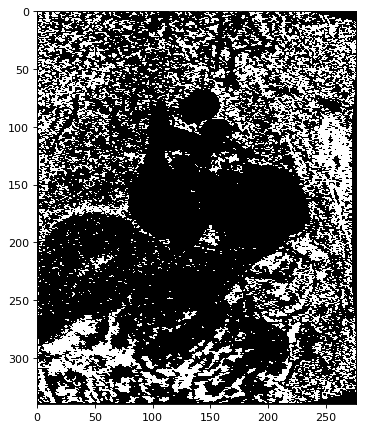

Reading Dicom directory: D:\small\tests\0006-0AE4R74L-1900-01-01\1.3.12.2.1107.5.99.2.1013.30000008030612131778100072178
merging files: 34
Failed to merge in D:\small\tests\0006-0AE4R74L-1900-01-01\1.3.12.2.1107.5.99.2.1013.30000008030612131778100072178, error: Exception thrown in SimpleITK ImageSeriesReader_Execute: c:\d\vs14-win64-pkg\simpleitk-build\itk-prefix\include\itk-4.13\itkImageFileReader.hxx:350:
ImageIO returns IO region that does not fully contain the requested regionRequested region: ImageRegion (000000B2C4BE6C70)
  Dimension: 3
  Index: [0, 0, 0]
  Size: [512, 512, 1]
StreamableRegion region: ImageRegion (000000B2C4BE6CD0)
  Dimension: 3
  Index: [0, 0, 0]
  Size: [484, 484, 1]



In [11]:
"""
merge all series with different timestemps
Patient 0001
1 New Studies
52 New Series
1258 New Instances)
StudyID = 0016625027
Define data directory
"""
# patient 0001
series_src = 'D:\\small\\tests\\0006-0AE4R74L-1900-01-01\\'
series_dest = 'D:\\small\\tests\\0006_merged_per_series'
suffix = '.dcm'

merge_all_subdirs(series_src, series_dest, suffix)

In [15]:
"""
merge all series with different timestemps
for patient 0706, file extension .dcm will end in an error
itk::ERROR: GDCMImageIO(0x7fe1a5f1ead0): A Floating point buffer was passed but the stored pixel type was not specified.
This is currently not supported
--> changed merging method to cast all floating types to uint 16
Patient 0706
1 New Studies
11 New Series
1336 New Instances

File Extension .mha runs, whats the difference???
"""
# patient 0706
series_src = 'data/raw/0706-ZY8H5791-2005-06-16'
series_dest = 'data/processed/merged_per_series/0706-ZY8H5791-2005-06-16'
suffix = '.dcm'

merge_all_subdirs(series_src, series_dest, suffix)

Folders in source: 11
Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614555551383
merging files: 105
image size: (256, 256, 105)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/0.dcm


interactive(children=(IntSlider(value=52, description='z', max=104), Output()), _dom_classes=('widget-interact…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614513735374
merging files: 105
image size: (256, 256, 105)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/1.dcm


interactive(children=(IntSlider(value=52, description='z', max=104), Output()), _dom_classes=('widget-interact…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061615051803408
merging files: 96
image size: (256, 256, 96)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/2.dcm


interactive(children=(IntSlider(value=47, description='z', max=95), Output()), _dom_classes=('widget-interact'…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061615180007449
merging files: 110
image size: (512, 512, 110)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/3.dcm


interactive(children=(IntSlider(value=54, description='z', max=109), Output()), _dom_classes=('widget-interact…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614322310338
merging files: 64
image size: (256, 256, 64)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/4.dcm


interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061615121925417
merging files: 105
image size: (256, 256, 105)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/5.dcm


interactive(children=(IntSlider(value=52, description='z', max=104), Output()), _dom_classes=('widget-interact…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061615014245399
merging files: 26
image size: (256, 256, 26)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/6.dcm


interactive(children=(IntSlider(value=12, description='z', max=25), Output()), _dom_classes=('widget-interact'…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614221471329
merging files: 320
image size: (256, 256, 320)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/7.dcm


interactive(children=(IntSlider(value=159, description='z', max=319), Output()), _dom_classes=('widget-interac…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614440812356
merging files: 90
image size: (256, 256, 90)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/8.dcm


interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614480173365
merging files: 105
image size: (256, 256, 105)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/9.dcm


interactive(children=(IntSlider(value=52, description='z', max=104), Output()), _dom_classes=('widget-interact…

Reading Dicom directory: data/raw/0706-ZY8H5791-2005-06-16/1.3.46.670589.11.0.0.11.4.2.0.5167.5.4188.2005061614385196347
merging files: 210
image size: (256, 256, 210)
image type before casting: 64-bit float
image type after casting: 16-bit unsigned integer
Writing image: data/processed/merged_per_series/0706-ZY8H5791-2005-06-16/10.dcm


interactive(children=(IntSlider(value=104, description='z', max=209), Output()), _dom_classes=('widget-interac…

In [ ]:
src1 = 'data/raw/0001_small/1.3.12.2.1107.5.99.2.1013.30000008030612131778100062857'
src2 = 'data/raw/0001_small/1.3.12.2.1107.5.99.2.1013.30000008030612131778100062911'
dest = 'data/processed/small/test1'
os.listdir(os.getcwd())

fw1 = FileWalker(MyDicomfile, src_dir=src1, dest_dir=dest)
fw2 = FileWalker(MyDicomfile, src_dir=src2, dest_dir=dest)
#fw.log_stats()